In [17]:
# ======== CONFIGURATION CELL ========
# 6 experiment configurations varying: batch_size, learning_rate, num_epochs

EXPERIMENT_CONFIGS = [
    {
        "id": "CONFIGURATION-1",
        "model_name": "distilbert-base-uncased",
        "learning_rate": 2e-5,
        "num_epochs": 1
    },
    {
        "id": "CONFIGURATION-2",
        "model_name": "distilbert-base-uncased",
        "learning_rate": 2e-5,
        "num_epochs": 2
    },
    {
        "id": "CONFIGURATION-3",
        "model_name": "distilbert-base-uncased",
        "learning_rate": 2e-5,
        "num_epochs": 3
    },
    {
        "id": "CONFIGURATION-4",
        "model_name": "distilbert-base-uncased",
        "learning_rate": 5e-5,
        "num_epochs": 1
    },
    {
        "id": "CONFIGURATION-5",
        "model_name": "distilbert-base-uncased",
        "learning_rate": 5e-5,
        "num_epochs": 2
    },
    {
        "id": "CONFIGURATION-6",
        "model_name": "distilbert-base-uncased",
        "learning_rate": 5e-5,
        "num_epochs": 3
    },
]

# Choose which configuration to run (0..5)
CURRENT_EXPERIMENT_INDEX = 0  # <-- change this for each configuration
NUM_RUNS_PER_CONFIG = 5  # <-- change this to 1,2,3,4,5 for the other runs

# Please modify this field with your name
MACHINE_ID = "PC_Agustin"

CONFIG = EXPERIMENT_CONFIGS[CURRENT_EXPERIMENT_INDEX]
print("Current configuration:", CONFIG["id"])
print(CONFIG)

Current configuration: CONFIGURATION-1
{'id': 'CONFIGURATION-1', 'model_name': 'distilbert-base-uncased', 'learning_rate': 2e-05, 'num_epochs': 1}


In [18]:
import numpy as np
import pandas as pd
import os

# confirm VS Code sees your data folder:
print(os.listdir("../data"))

['Fake.csv', 'val.csv', 'test.csv', 'merged_dataset.csv', 'README.md', 'train.csv', 'True.csv']


In [19]:
# Load pre-split data
train_df = pd.read_csv("../data/train.csv")
val_df   = pd.read_csv("../data/val.csv")
test_df  = pd.read_csv("../data/test.csv")

train_df.head()

,title,text,subject,date,label,text_full
0,SocGen says no wrongdoing in handling of Natio...,PARIS - French bank Societe Generale on Wedne...,worldnews,"November 22, 2017",1,SocGen says no wrongdoing in handling of Natio...
1,North Carolina governor concedes election to D...,"WINSTON-SALEM, N.C. - North Carolina Governor...",politicsNews,"December 5, 2016",1,North Carolina governor concedes election to D...
2,TRUMP FEVER! W. VA Dem Senator Says He Won’t V...,Civil political discourse took a beating in We...,left-news,"Aug 7, 2017",0,TRUMP FEVER! W. VA Dem Senator Says He Won’t V...
3,New York vows to sue Trump over immigrant chil...,- New York and Washington state on Monday vow...,politicsNews,"September 4, 2017",1,New York vows to sue Trump over immigrant chil...
4,Orlando killer expressed support for multiple ...,"ORLANDO, Fla. - Orlando nightclub killer Omar...",politicsNews,"June 12, 2016",1,Orlando killer expressed support for multiple ...


In [20]:
import re

# Simple sanity check: make sure Reuters source tags were removed in preprocessing
pattern = r'[\(\[]\s*Reuters\s*[\)\]]|^\s*Reuters\s*-\s*'


def check_reuters(df, split_name):
    cols_to_check = [c for c in ["text_full", "text", "title"] if c in df.columns]
    total = 0
    for col in cols_to_check:
        count = df[col].astype(str).str.contains(pattern, regex=True).sum()
        print(f"{split_name}: {count} rows still contain Reuters-tag pattern in '{col}'")
        total += count
    if total == 0:
        print(f"✅ No Reuters source tags found in {split_name} split.\n")
    else:
        print(f"⚠️ WARNING: Found {total} Reuters-tagged rows in {split_name}.\n"
              f"   → You may need to re-run preprocessing.py to regenerate the CSVs.\n")


check_reuters(train_df, "train")
check_reuters(val_df, "val")
check_reuters(test_df, "test")


train: 8 rows still contain Reuters-tag pattern in 'text_full'
train: 8 rows still contain Reuters-tag pattern in 'text'
train: 0 rows still contain Reuters-tag pattern in 'title'
⚠️ WARNING: Found 16 Reuters-tagged rows in train.
   → You may need to re-run preprocessing.py to regenerate the CSVs.

val: 1 rows still contain Reuters-tag pattern in 'text_full'
val: 1 rows still contain Reuters-tag pattern in 'text'
val: 0 rows still contain Reuters-tag pattern in 'title'
⚠️ WARNING: Found 2 Reuters-tagged rows in val.
   → You may need to re-run preprocessing.py to regenerate the CSVs.

test: 2 rows still contain Reuters-tag pattern in 'text_full'
test: 2 rows still contain Reuters-tag pattern in 'text'
test: 0 rows still contain Reuters-tag pattern in 'title'
⚠️ WARNING: Found 4 Reuters-tagged rows in test.
   → You may need to re-run preprocessing.py to regenerate the CSVs.



In [21]:
# Our input text and labels
X_train_text = train_df["text_full"].astype(str).tolist()
y_train      = train_df["label"].tolist()

X_val_text   = val_df["text_full"].astype(str).tolist()
y_val        = val_df["label"].tolist()

X_test_text  = test_df["text_full"].astype(str).tolist()
y_test       = test_df["label"].tolist()

len(X_train_text), len(X_val_text), len(X_test_text)

(35918, 4490, 4490)

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

# Define metric computation
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    acc = accuracy_score(labels, preds)
    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

In [23]:
################################################### NOTES ###################################################
# We use our preprocessed CSVs → X_train_text, y_train, etc.
# No more transformed_text_title_combined or Kaggle paths.
# DistilBERT sees: text_full (title + body) and label (0 = fake, 1 = real).
# We use train + val for training/validation; test stays untouched for final evaluation.
#############################################################################################################

import os
os.environ["WANDB_DISABLED"] = "true"  # disable Weights & Biases spam

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset
import torch

# Prefer MPS (Apple Silicon), then CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple MPS device")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Final device: {device}")


# 1. Load tokenizer (from CONFIG)
tokenizer = AutoTokenizer.from_pretrained(CONFIG["model_name"])

# 2. Convert our lists -> Hugging Face Dataset objects
train_ds = Dataset.from_dict({"text": X_train_text, "label": y_train})
val_ds   = Dataset.from_dict({"text": X_val_text,   "label": y_val})
test_ds  = Dataset.from_dict({"text": X_test_text,  "label": y_test})

# 3. Tokenization
MAX_LENGTH = 256

def tokenize_function(batch):
    return tokenizer(
        batch["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
    )

tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val   = val_ds.map(tokenize_function,   batched=True)
tokenized_test  = test_ds.map(tokenize_function,  batched=True)


# 4. Data collator (handles padding dynamically)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Using Apple MPS device
Final device: mps


Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

In [ ]:
from transformers import set_seed
import csv
import time
import shutil

log_csv_path = "../experiment_results.csv"

# Root folder para los TXT legibles
txt_logs_root = "../run_logs_results"
os.makedirs(txt_logs_root, exist_ok=True)

BATCH_SIZE = 32

csv_fieldnames = [
    "timestamp",
    "experiment_id",
    "run_index",
    "model_name",
    "machine_id",
    "learning_rate",
    "num_epochs",
    "val_accuracy",
    "val_precision",
    "val_recall",
    "val_f1",
]

csv_exists = os.path.isfile(log_csv_path)
if not csv_exists:
    with open(log_csv_path, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=csv_fieldnames)
        writer.writeheader()

for run_idx in range(NUM_RUNS_PER_CONFIG):
    print("=" * 80)
    print(f"RUN {run_idx + 1}/{NUM_RUNS_PER_CONFIG}  |  {CONFIG['id']}")
    print("=" * 80)

    # 0) Different Seed per run
    seed_value = 42 + run_idx
    set_seed(seed_value)

    # 1) Reinitialize model from DistilBERT base
    model = AutoModelForSequenceClassification.from_pretrained(
        CONFIG["model_name"],
        num_labels=2,
    )
    model.to(device)

    # 2) Directorios temporales para checkpoints/logs de este run
    run_output_dir = f"../results/{CONFIG['id']}/run_{run_idx + 1}"
    run_logging_dir = f"../logs/{CONFIG['id']}/run_{run_idx + 1}"

    # 3) TrainingArguments
    training_args = TrainingArguments(
        output_dir=run_output_dir,
        learning_rate=CONFIG["learning_rate"],
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=CONFIG["num_epochs"],
        logging_dir=run_logging_dir,
        report_to=[],
        seed=seed_value,
        eval_strategy="no",
        save_strategy="no",
        save_total_limit=1,
        metric_for_best_model="eval_f1",
        logging_strategy="epoch",
    )

    # 4) Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # 5) Training (the model in the end is the one of the last epoch)
    trainer.train()
    print("Training finished.")

    # 6) Evaluate only on the validation with the model of the last epoch.
    val_results = trainer.evaluate()

    def pretty_print_metrics(name, metrics):
        print(f"\n{name} metrics:")
        print(f"  Accuracy : {metrics.get('eval_accuracy', 0):.4f}")
        print(f"  Precision: {metrics.get('eval_precision', 0):.4f}")
        print(f"  Recall   : {metrics.get('eval_recall', 0):.4f}")
        print(f"  F1-score : {metrics.get('eval_f1', 0):.4f}")

    pretty_print_metrics("Validation", val_results)
    print()

    # 7) Save the model of this run (last epoch) in a stable folder.
    final_model_dir = os.path.join("../models", CONFIG["id"], f"run_{run_idx + 1}")
    os.makedirs(final_model_dir, exist_ok=True)

    trainer.save_model(final_model_dir)
    tokenizer.save_pretrained(final_model_dir)

    print(f"💾 Last epoch model for this run: {final_model_dir}")

    # 7.1) Delete temporary folder of results (to maintain clean)
    shutil.rmtree(run_output_dir, ignore_errors=True)

    # 8) Log a CSV immediately after finishing the run.
    timestamp = time.strftime("%Y-%m-%d %H:%M:%S")

    row = {
        "timestamp": timestamp,
        "experiment_id": CONFIG["id"],
        "run_index": run_idx + 1,
        "model_name": CONFIG["model_name"],
        "machine_id": MACHINE_ID,
        "learning_rate": CONFIG["learning_rate"],
        "num_epochs": CONFIG["num_epochs"],
        "val_accuracy": val_results.get("eval_accuracy"),
        "val_precision": val_results.get("eval_precision"),
        "val_recall": val_results.get("eval_recall"),
        "val_f1": val_results.get("eval_f1"),
    }

    with open(log_csv_path, "a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=csv_fieldnames)
        writer.writerow(row)

    print("📝 Logged validation metrics to experiment_results.csv")

    # 9) Log TXT legible por run
    config_logs_dir = os.path.join(txt_logs_root, CONFIG["id"])
    os.makedirs(config_logs_dir, exist_ok=True)

    txt_path = os.path.join(config_logs_dir, f"run_{run_idx + 1}.txt")
    with open(txt_path, "w") as f:
        f.write(f"Timestamp: {timestamp}\n")
        f.write(f"Experiment ID: {CONFIG['id']}\n")
        f.write(f"Run index: {run_idx + 1}\n")
        f.write(f"Model: {CONFIG['model_name']}\n")
        f.write(f"Machine: {MACHINE_ID}\n")
        f.write(f"Learning rate: {CONFIG['learning_rate']}\n")
        f.write(f"Epochs: {CONFIG['num_epochs']}\n")

        f.write("Validation metrics:\n")
        f.write(f"  Accuracy:  {val_results.get('eval_accuracy')}\n")
        f.write(f"  Precision: {val_results.get('eval_precision')}\n")
        f.write(f"  Recall:    {val_results.get('eval_recall')}\n")
        f.write(f"  F1:        {val_results.get('eval_f1')}\n")

    print(f"📄 Saved TXT log to: {txt_path}")
    print(f"✅ Finished run {run_idx + 1}/{NUM_RUNS_PER_CONFIG} for {CONFIG['id']}\n")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RUN 1/5  |  CONFIGURATION-1


/var/folders/09/f1bm6mk51zn1sc1fthq_md9m0000gn/T/ipykernel_1706/802827474.py:72: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/Users/agust/Desktop/Agustin/UPM/Repositories UPM/Milestone/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


In [4]:
import pandas as pd

# Load all logged runs
results = pd.read_csv("../experiment_results.csv")

# Group by configuration + hyperparams
group_cols = [
    "experiment_id",
    "model_name",
    "learning_rate",
    "num_epochs",
]

summary = (
    results
    .groupby(group_cols)
    .agg(
        runs=("run_index", "nunique"),
        val_accuracy_mean=("val_accuracy", "mean"),
        val_accuracy_std=("val_accuracy", "std"),
        val_f1_mean=("val_f1", "mean"),
        val_f1_std=("val_f1", "std"),
    )
    .reset_index()
    .sort_values(["experiment_id"])
)

summary

,experiment_id,model_name,learning_rate,batch_size,num_epochs,max_length,runs,val_accuracy_mean,val_accuracy_std,val_f1_mean,val_f1_std,test_accuracy_mean,test_accuracy_std,test_f1_mean,test_f1_std
0,CONFIGURATION-1,distilbert-base-uncased,0.00002,16,1,256,2,0.999666,0.000157,0.999650,0.000165,0.998998,0.000157,0.998949,0.000165
1,CONFIGURATION-1,distilbert-base-uncased,0.00002,32,1,256,3,0.999703,0.000129,0.999689,0.000135,0.998961,0.000257,0.998910,0.000270
2,CONFIGURATION-1,distilbert-base-uncased,0.00002,64,1,256,5,0.999777,0.000157,0.999767,0.000165,NaN,NaN,NaN,NaN
3,CONFIGURATION-2,distilbert-base-uncased,0.00002,16,3,256,5,0.999955,0.000100,0.999953,0.000104,NaN,NaN,NaN,NaN
4,CONFIGURATION-3,distilbert-base-uncased,0.00005,16,2,256,5,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN
5,CONFIGURATION-4,distilbert-base-uncased,0.00002,32,2,256,5,0.999955,0.000100,0.999953,0.000104,NaN,NaN,NaN,NaN
6,CONFIGURATION-5,distilbert-base-uncased,0.00005,32,1,256,5,0.999955,0.000100,0.999953,0.000104,NaN,NaN,NaN,NaN
7,CONFIGURATION-6,distilbert-base-uncased,0.00005,32,3,256,5,1.000000,0.000000,1.000000,0.000000,NaN,NaN,NaN,NaN
8,exp1_bs16_lr2e-5_ep1,distilbert-base-uncased,0.00002,16,1,256,1,0.999777,NaN,0.999767,NaN,0.998664,NaN,0.998598,NaN


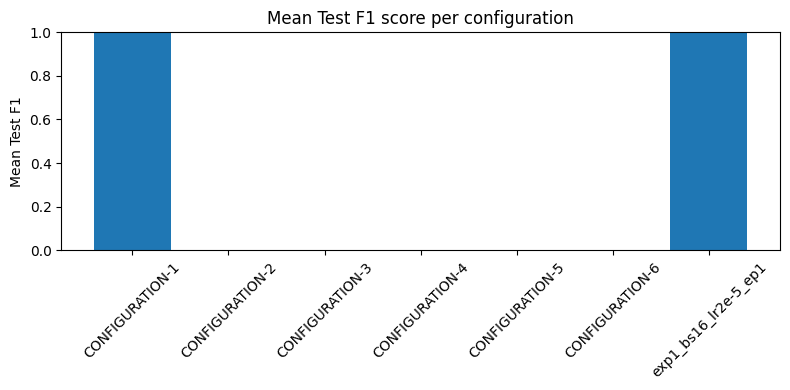

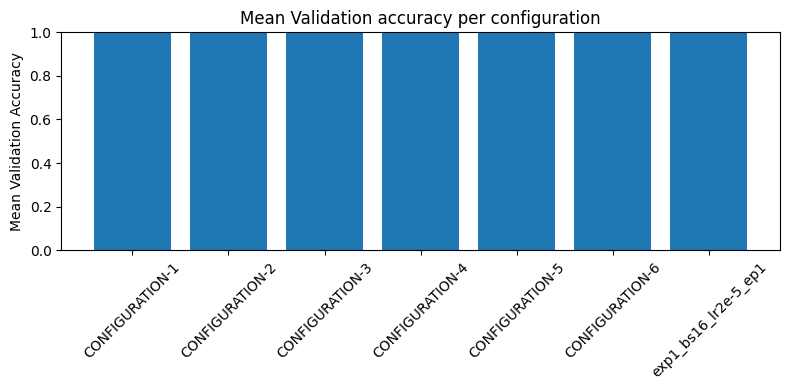

In [17]:
import matplotlib.pyplot as plt

# Simple bar plot: mean Test F1 per configuration
plt.figure(figsize=(8, 4))
plt.bar(summary["experiment_id"], summary["test_f1_mean"])
plt.xticks(rotation=45)
plt.ylabel("Mean Test F1")
plt.title("Mean Test F1 score per configuration")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

# Optional: bar plot for Validation Accuracy
plt.figure(figsize=(8, 4))
plt.bar(summary["experiment_id"], summary["val_accuracy_mean"])
plt.xticks(rotation=45)
plt.ylabel("Mean Validation Accuracy")
plt.title("Mean Validation accuracy per configuration")
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
import os

# 1) Load all the results
results = pd.read_csv("../experiment_results.csv")

# 2) Filter specifically this configuration.
config_id = CONFIG["id"]
config_rows = results[results["experiment_id"] == config_id]

# 3) Choose the run with the best F1 in Validation
best_row = config_rows.sort_values("val_f1", ascending=False).iloc[0]
best_run = int(best_row["run_index"])

print(f"🏆 Best run for {config_id} based on validation F1:")
display(best_row)

# 4) Load that model
best_model_dir = os.path.join("../models", config_id, f"run_{best_run}")
print(f"\nLoading best model from: {best_model_dir}")

best_model = AutoModelForSequenceClassification.from_pretrained(best_model_dir)
best_model.to(device)

# 5) Create a Trainer only for evaluation in test.
test_args = TrainingArguments(
    output_dir="./tmp_best_eval",
    per_device_eval_batch_size=BATCH_SIZE,
    report_to=[],
)

best_trainer = Trainer(
    model=best_model,
    args=test_args,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

test_results = best_trainer.evaluate()

print("\n📊 FINAL TEST METRICS (single evaluation for this configuration):")
print(f"  Accuracy : {test_results.get('eval_accuracy', 0):.4f}")
print(f"  Precision: {test_results.get('eval_precision', 0):.4f}")
print(f"  Recall   : {test_results.get('eval_recall', 0):.4f}")
print(f"  F1-score : {test_results.get('eval_f1', 0):.4f}")


🏆 Best run for CONFIGURATION-6 based on validation F1:


timestamp             2025-11-23 13:23:26
experiment_id             CONFIGURATION-6
run_index                               1
model_name        distilbert-base-uncased
learning_rate                     0.00005
batch_size                             32
num_epochs                              3
max_length                            256
val_accuracy                          1.0
val_precision                         1.0
val_recall                            1.0
val_f1                                1.0
test_accuracy                         NaN
test_precision                        NaN
test_recall                           NaN
test_f1                               NaN
Name: 31, dtype: object


Loading best model from: ../models/CONFIGURATION-6/run_1


/var/folders/09/f1bm6mk51zn1sc1fthq_md9m0000gn/T/ipykernel_12014/1838334865.py:34: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  best_trainer = Trainer(
/Users/agust/Desktop/Agustin/UPM/Repositories UPM/Milestone/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 FINAL TEST METRICS (single evaluation for this configuration):
  Accuracy : 0.9993
  Precision: 1.0000
  Recall   : 0.9986
  F1-score : 0.9993


In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load fine-tuned model + tokenizer from disk
model_path = "../models/distilbert_finetuned"
loaded_model = AutoModelForSequenceClassification.from_pretrained(model_path)
loaded_tokenizer = AutoTokenizer.from_pretrained(model_path)

loaded_model.eval()

# Label mapping: 0 = Fake, 1 = Real (our convention)
label_names = ["Fake", "Real"]

# Example news texts (you can change these to whatever you like) (ChatGPT's idea)
sample_texts = [
    "Government announces new education reform to support low-income students.",
    "Shocking! Scientists prove that drinking only coffee for a week makes you immortal.",
    "Major tech company releases open-source AI model for medical diagnosis.",
    "Experts claim that the moon will crash into Earth next year according to secret documents.",
]

for text in sample_texts:
    # Tokenize
    inputs = loaded_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
    )

    # Get predictions
    with torch.no_grad():
        outputs = loaded_model(**inputs)
        logits = outputs.logits
        predicted_class_id = torch.argmax(logits, dim=-1).item()

    print("Text:", text)
    print("Prediction:", label_names[predicted_class_id])
    print("-" * 80)

Text: Government announces new education reform to support low-income students.
Prediction: Real
--------------------------------------------------------------------------------
Text: Shocking! Scientists prove that drinking only coffee for a week makes you immortal.
Prediction: Fake
--------------------------------------------------------------------------------
Text: Major tech company releases open-source AI model for medical diagnosis.
Prediction: Fake
--------------------------------------------------------------------------------
Text: Experts claim that the moon will crash into Earth next year according to secret documents.
Prediction: Fake
--------------------------------------------------------------------------------


In [24]:
# Pick one known real and one known fake from your data
real_example = true_example = train_df[train_df["label"] == 1]["text_full"].iloc[0]
fake_example = train_df[train_df["label"] == 0]["text_full"].iloc[0]

def predict_text(text):
    inputs = loaded_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH,
    )
    with torch.no_grad():
        outputs = loaded_model(**inputs)
        pred_id = torch.argmax(outputs.logits, dim=-1).item()
    return label_names[pred_id]

print("REAL example pred:", predict_text(real_example))
print("FAKE example pred:", predict_text(fake_example))

REAL example pred: Real
FAKE example pred: Fake
